# Model Evaluation on ImageNet Validation Set

This notebook evaluates the colorization model on a random subset of 1000 images from the ImageNet validation set.

**Metrics:**
- **RMSE**: Root Mean Square Error (ab channel)
- **PSNR**: Peak Signal-to-Noise Ratio (RGB)
- **AuC**: Area Under Curve of the error cumulative distribution function (Zhang et al.)
- **Colorfulness Ratio**: Ratio of predicted image colorfulness to ground truth colorfulness

In [20]:
import os
import sys
import json
import random
import time
import warnings
from pathlib import Path
from collections import defaultdict

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Add project root to path
sys.path.append(os.path.abspath(''))

from configs.config import (
    IMAGE_SIZE, DEVICE, CHECKPOINTS_DIR, NUM_COLOR_CLASSES,
    T_ANNEAL, BASE_DIR, DATA_DIR, VAL_DIR
)
from src.model import ColorizationModel
from src.color_utils import decode_annealed_mean, rgb_to_lab, lab_to_rgb

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Define Metrics

In [21]:
def calculate_psnr(img_true, img_pred):
    mse = np.mean((img_true - img_pred) ** 2)
    if mse == 0: return 100.0
    return 10 * np.log10(1.0 / mse)

def calculate_accuracy_auc(diff_ab):
    thresholds = np.linspace(0, 150, 151)
    accs = [np.mean(diff_ab <= t) for t in thresholds]
    auc = np.trapz(accs, thresholds) / 150.0
    return auc, accs

def hasler_colorfulness(img_rgb):
    R, G, B = img_rgb[:,:,0], img_rgb[:,:,1], img_rgb[:,:,2]
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    std_root = np.sqrt(np.std(rg)**2 + np.std(yb)**2)
    mean_root = np.sqrt(np.mean(rg)**2 + np.mean(yb)**2)
    return std_root + (0.3 * mean_root)

## 2. Load Data (Random 1000 Images)

In [22]:
print(f"Searching for images in: {VAL_DIR}")
val_path = Path(VAL_DIR)

# Find all images recursively
all_images = list(val_path.rglob("*.JPEG")) + list(val_path.rglob("*.jpg")) + list(val_path.rglob("*.png"))
print(f"Found {len(all_images)} total validation images.")

# Sample 1000
NUM_SAMPLES = 1000
if len(all_images) > NUM_SAMPLES:
    eval_paths = random.sample(all_images, NUM_SAMPLES)
else:
    eval_paths = all_images
    
eval_paths = [str(p) for p in eval_paths]
print(f"Selected {len(eval_paths)} images for evaluation.")

Searching for images in: c:\Users\kaluc\General\02_projekty\colorization\imagenet-object-localization-challenge\ILSVRC\Data\CLS-LOC\val
Found 50000 total validation images.
Selected 1000 images for evaluation.


## 3. Load Model

In [23]:
ckpt_path = os.path.join(CHECKPOINTS_DIR, "checkpoint_last.pth.tar")
if not os.path.exists(ckpt_path):
    print(f"WARNING: Model not found at {ckpt_path}")
else:
    print(f"Loading model from: {ckpt_path}")
    model = ColorizationModel(num_classes=NUM_COLOR_CLASSES).to(DEVICE)
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    print("Model loaded successfully.")

Loading model from: c:\Users\kaluc\General\02_projekty\colorization\checkpoints\checkpoint_last.pth.tar
Model loaded successfully.


## 4. Run Inference

In [24]:
metrics = defaultdict(list)
results_data = []
vis_dir = os.path.join(BASE_DIR, "evaluation_results")
os.makedirs(vis_dir, exist_ok=True)

start_time = time.time()

for idx, img_path in enumerate(eval_paths):
    if idx % 100 == 0: print(f"Processing {idx}/{len(eval_paths)}...")
    
    try:
        # Load & Preprocess
        img_bgr = cv2.imread(img_path)
        if img_bgr is None: continue
        img_rgb_orig = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb_orig, (IMAGE_SIZE, IMAGE_SIZE))
        img_float = img_resized.astype(np.float32) / 255.0
        
        # Lab Conversion
        lab_gt = rgb_to_lab(img_float)
        L_gt = lab_gt[:, :, 0]
        ab_gt = lab_gt[:, :, 1:]
        
        # Inference
        # Normalize L to 0..1 per model requirement
        L_input = L_gt / 100.0
        L_tensor = torch.from_numpy(L_input).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            logits = model(L_tensor)
            ab_decoded = decode_annealed_mean(logits, T=T_ANNEAL)
            ab_pred = ab_decoded.squeeze(0).permute(1, 2, 0).cpu().numpy()
            
        # Resize pred if needed (should be 224x224 already but good to be safe)
        if ab_pred.shape[:2] != L_gt.shape[:2]:
            ab_pred = cv2.resize(ab_pred, (L_gt.shape[1], L_gt.shape[0]))

        # Reconstruction
        lab_pred = np.dstack((L_gt, ab_pred))
        img_rgb_pred = lab_to_rgb(lab_pred).clip(0, 1)
        
        # Metrics
        mse = np.mean((ab_pred - ab_gt) ** 2)
        rmse = np.sqrt(mse)
        psnr = calculate_psnr(img_float, img_rgb_pred)
        
        dist_map = np.sqrt(np.sum((ab_pred - ab_gt) ** 2, axis=2))
        auc, accs = calculate_accuracy_auc(dist_map)
        
        cf_pred = hasler_colorfulness(img_rgb_pred)
        cf_gt = hasler_colorfulness(img_float)
        cf_ratio = cf_pred / (cf_gt + 1e-6)
        
        metrics["rmse"].append(rmse)
        metrics["psnr"].append(psnr)
        metrics["auc"].append(auc)
        metrics["acc5"].append(accs[5])
        metrics["cf_ratio"].append(cf_ratio)
        metrics["cf_pred"].append(cf_pred)
        metrics["cf_gt"].append(cf_gt)
        
        # Save 10 random visualizations (during loop)
        if idx < 10 or (idx % 100 == 0 and idx < 1000):
             vis = np.hstack((img_float, np.stack([L_input]*3, axis=-1), img_rgb_pred))
             vis = (vis * 255).clip(0, 255).astype(np.uint8)
             vis_bgr = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
             cv2.imwrite(os.path.join(vis_dir, f"sample_{idx}.png"), vis_bgr)
             
    except Exception as e:
        print(f"Error on {img_path}: {e}")

duration = time.time() - start_time
print(f"Inference finished in {duration:.1f}s")

Processing 0/1000...


C:\Users\kaluc\AppData\Local\Temp\ipykernel_12872\1319145383.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(accs, thresholds) / 150.0


Processing 100/1000...
Processing 200/1000...
Processing 300/1000...
Processing 400/1000...
Processing 500/1000...
Processing 600/1000...
Processing 700/1000...
Processing 800/1000...
Processing 900/1000...
Inference finished in 39.9s


## 5. Results & Visualization


       FINAL METRICS SUMMARY
Images Evaluated: 1000
RMSE Mean:       16.2591 +/- 6.9600
PSNR Mean:       20.92 +/- 3.92
AuC Mean:        0.8738 +/- 0.0618
Colorfulness Ratio: 1.1398 (Target: 1.0)
----------------------------------------


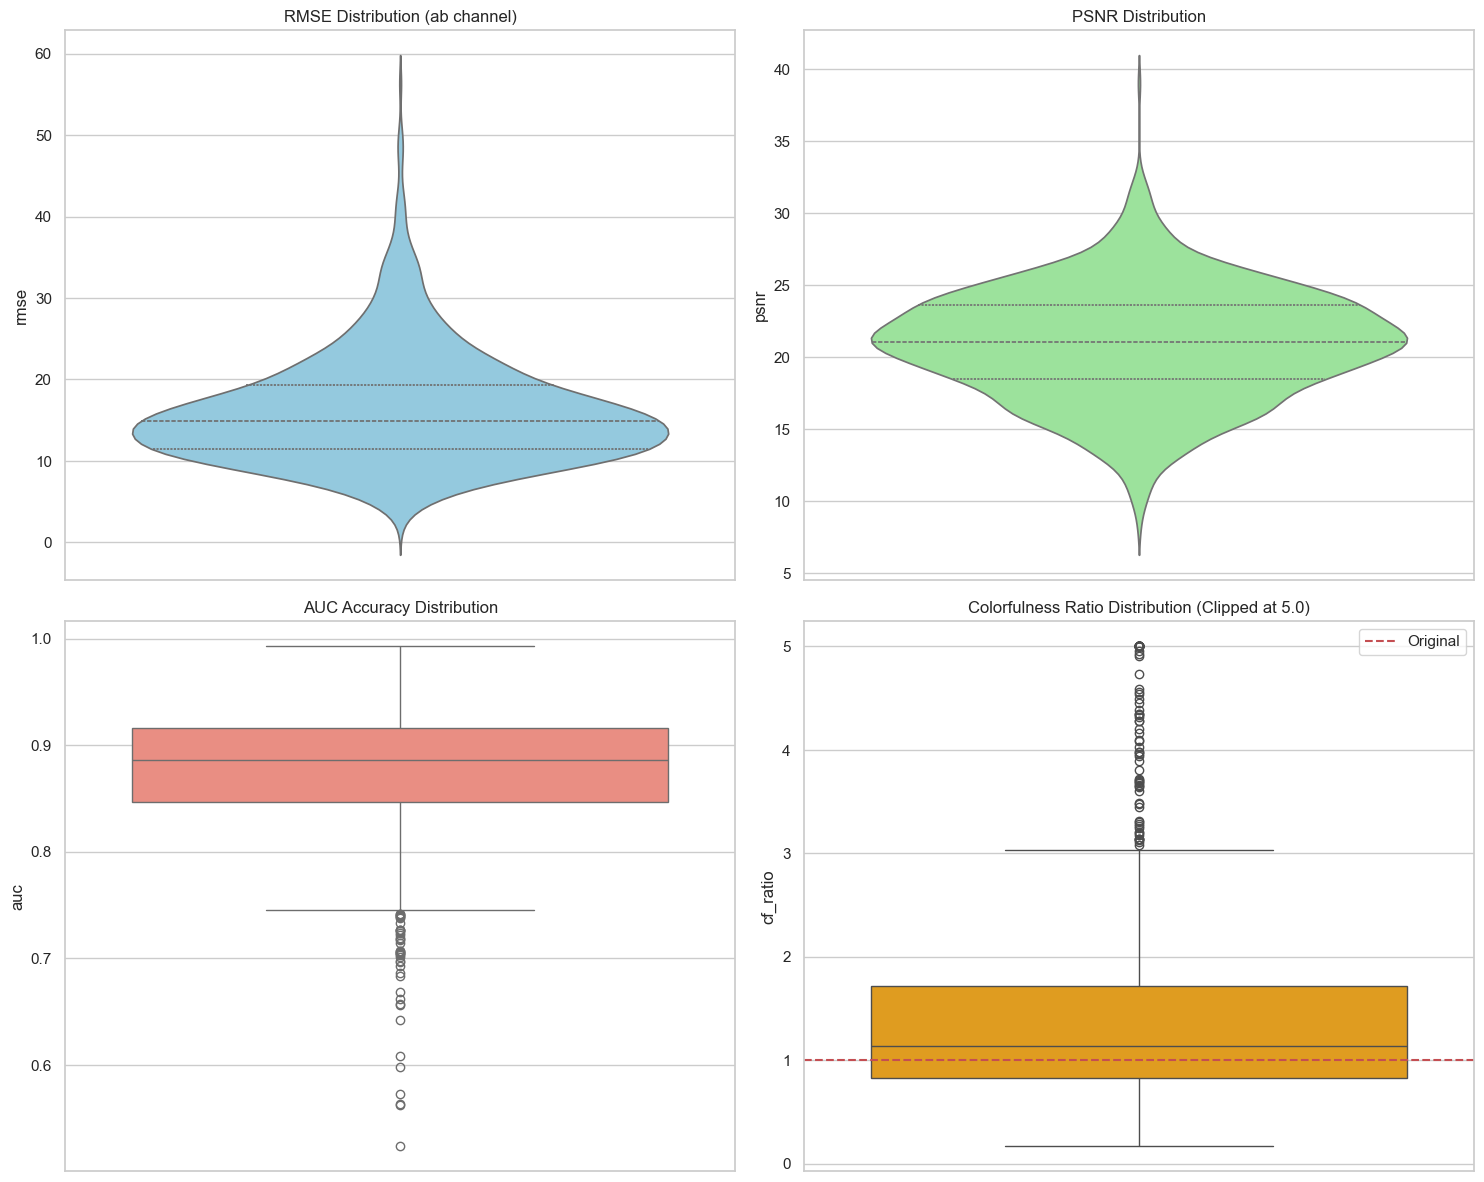


     RANDOM VISUALIZATION SAMPLES


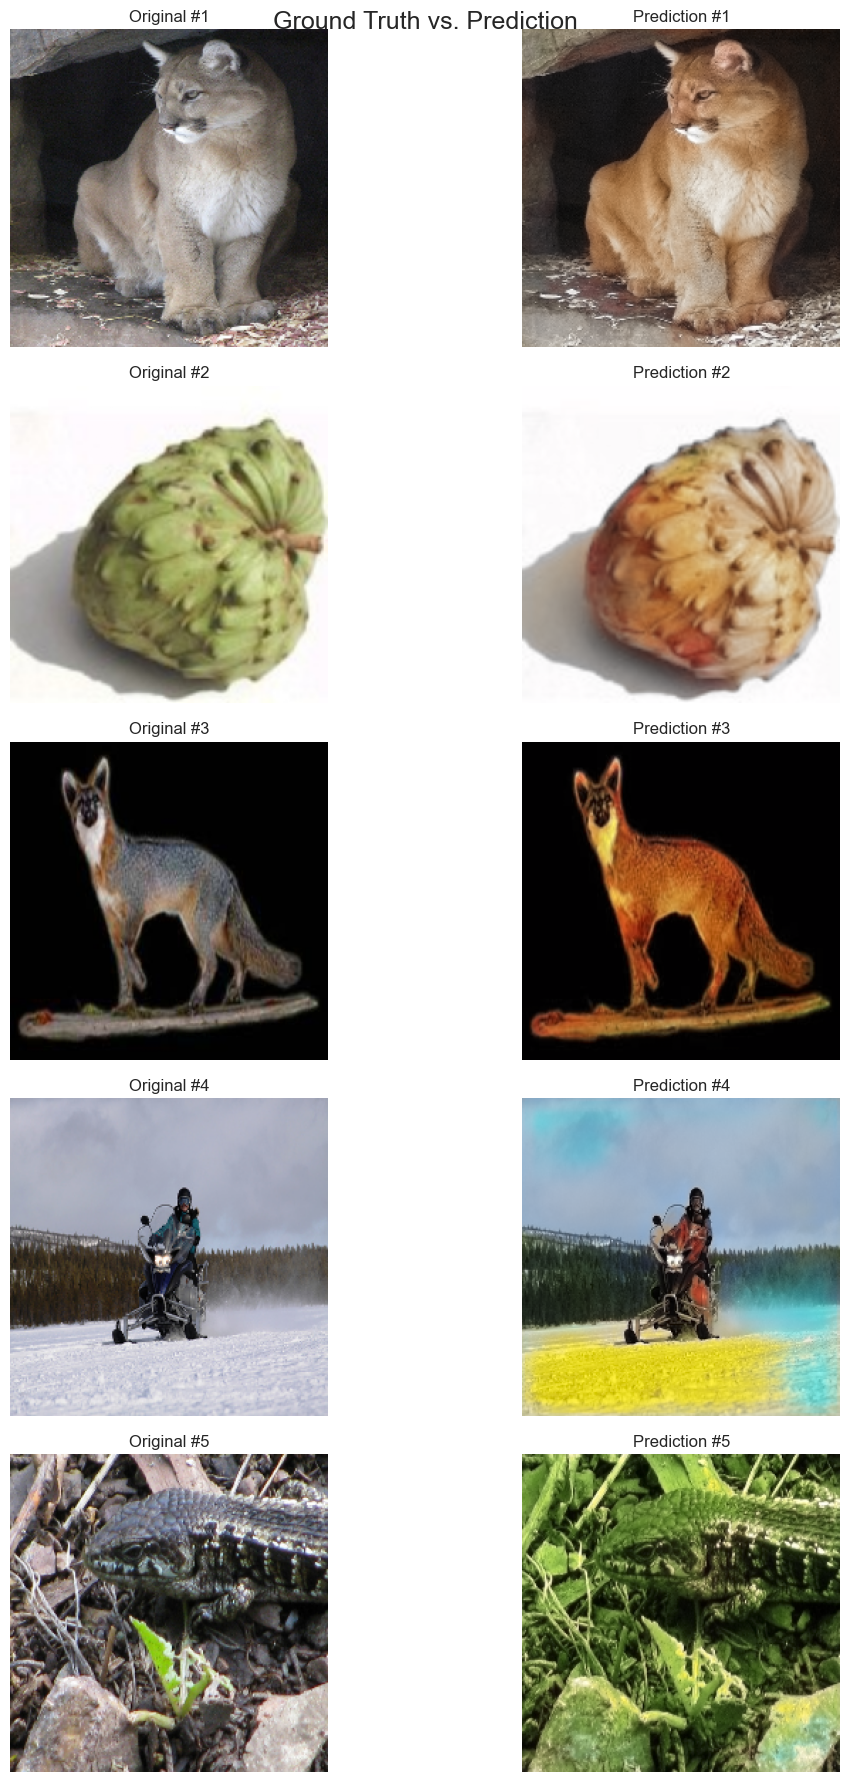

In [25]:
if len(metrics['rmse']) > 0:
    df = pd.DataFrame(metrics)
    
    # --- Global Summary ---
    print("\n" + "="*40)
    print("       FINAL METRICS SUMMARY")
    print("="*40)
    print(f"Images Evaluated: {len(df)}")
    print(f"RMSE Mean:       {df['rmse'].mean():.4f} +/- {df['rmse'].std():.4f}")
    print(f"PSNR Mean:       {df['psnr'].mean():.2f} +/- {df['psnr'].std():.2f}")
    print(f"AuC Mean:        {df['auc'].mean():.4f} +/- {df['auc'].std():.4f}")
    
    mean_cf_pred = df['cf_pred'].mean()
    mean_cf_gt = df['cf_gt'].mean()
    global_cf_ratio = mean_cf_pred / (mean_cf_gt + 1e-6)
    print(f"Colorfulness Ratio: {global_cf_ratio:.4f} (Target: 1.0)")
    print("-" * 40)

    # --- Distributions Plot (Box-plot & Violin-plot) ---
    if 'df' in locals() and not df.empty:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        sns.violinplot(data=df, y="rmse", ax=axes[0,0], inner="quartile", color="skyblue")
        axes[0,0].set_title("RMSE Distribution (ab channel)")

        sns.violinplot(data=df, y="psnr", ax=axes[0,1], inner="quartile", color="lightgreen")
        axes[0,1].set_title("PSNR Distribution")

        sns.boxplot(data=df, y="auc", ax=axes[1,0], color="salmon")
        axes[1,0].set_title("AUC Accuracy Distribution")

        # Handle weird range for CF Ratio (clip visual outliers)
        df_vis = df.copy()
        df_vis['cf_ratio'] = df_vis['cf_ratio'].clip(upper=5.0)

        sns.boxplot(data=df_vis, y="cf_ratio", ax=axes[1,1], color="orange")
        axes[1,1].set_title("Colorfulness Ratio Distribution (Clipped at 5.0)")
        axes[1,1].axhline(1.0, color='r', linestyle='--', label='Original')
        axes[1,1].legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Skipping plots.")
    
    # --- 5 Random Visualizations ---
    print("\n" + "="*40)
    print("     RANDOM VISUALIZATION SAMPLES")
    print("="*40)
    
    vis_samples = random.sample(eval_paths, 5)
    fig, axes = plt.subplots(5, 2, figsize=(12, 20))
    fig.suptitle('Ground Truth vs. Prediction', fontsize=18, y=0.92)
    
    for i, path in enumerate(vis_samples):
        # Infer again for visualization
        try:
            img_bgr = cv2.imread(path)
            img_rgb_orig = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb_orig, (IMAGE_SIZE, IMAGE_SIZE))
            img_float = img_resized.astype(np.float32) / 255.0
            
            lab_gt = rgb_to_lab(img_float)
            L_gt = lab_gt[:, :, 0]
            L_input = L_gt / 100.0
            L_tensor = torch.from_numpy(L_input).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
            
            with torch.no_grad():
                logits = model(L_tensor)
                ab_decoded = decode_annealed_mean(logits, T=T_ANNEAL)
                ab_pred = ab_decoded.squeeze(0).permute(1, 2, 0).cpu().numpy()
            
            if ab_pred.shape[:2] != L_gt.shape[:2]:
                ab_pred = cv2.resize(ab_pred, (L_gt.shape[1], L_gt.shape[0]))
                
            lab_pred = np.dstack((L_gt, ab_pred))
            img_rgb_pred = lab_to_rgb(lab_pred).clip(0, 1)
            
            # Plot
            axes[i, 0].imshow(img_float)
            axes[i, 0].set_title(f"Original #{i+1}", fontsize=12)
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(img_rgb_pred)
            axes[i, 1].set_title(f"Prediction #{i+1}", fontsize=12)
            axes[i, 1].axis('off')
            
        except Exception as e:
            print(f"Error visualizing {path}: {e}")
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("No successful metrics calculated. Check paths.")